<a href="https://colab.research.google.com/github/FabianaAlbuquerque97/AI-Fuzzy-Systems-and-Bayesian-Prediction/blob/main/Sistema_Diagn%C3%B3stico_M%C3%A9dico_com_Rede_Bayesiana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sistema de Diagnóstico Médico probabilístico com base em Rede Bayesiana

Trabalho de Inteligência Artificial - Questão 3

O objetivo de estimar o risco de infarto do miocárdio (IAM). O sistema considera dados clínicos, laboratoriais, histórico familiar, sintomas e especialmente variáveis de ressonância magnética cardíaca (RMC) do ventrículo esquerdo.

In [2]:
!pip install pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [21]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

import matplotlib.pyplot as plt
import itertools

In [22]:
# Estrutura da rede
model = DiscreteBayesianNetwork([
    ('Hipertensao', 'Risco'),
    ('Diabetes', 'Risco'),
    ('IMC', 'Risco'),
    ('LGE', 'Risco'),
    ('FEVE', 'Risco'),
    ('DorPeito', 'Risco'),
    ('FaltaAr', 'Risco'),
    ('Risco', 'Infarto')
])


In [23]:
# Variáveis binárias (0 = Não / Normal, 1 = Sim / Anormal)
cpd_hipertensao = TabularCPD('Hipertensao', 2, [[0.6], [0.4]])
cpd_diabetes = TabularCPD('Diabetes', 2, [[0.7], [0.3]])
cpd_imc = TabularCPD('IMC', 2, [[0.5], [0.5]])
cpd_lge = TabularCPD('LGE', 2, [[0.8], [0.2]])
cpd_feve = TabularCPD('FEVE', 2, [[0.7], [0.3]])
cpd_dorpeito = TabularCPD('DorPeito', 2, [[0.5], [0.5]])
cpd_faltaar = TabularCPD('FaltaAr', 2, [[0.6], [0.4]])


In [24]:
# Pontuação de risco:
# Cada variável "positiva" (valor 1) soma 1 ponto.
# Soma total (0 a 7) define Risco:
# 0-2 pontos → Baixo
# 3-4 pontos → Moderado
# 5-7 pontos → Alto

# Criar todas as combinações possíveis (2^7 = 128)

combinacoes = list(itertools.product([0, 1], repeat=7))
valores_baixo, valores_moderado, valores_alto = [], [], []

for combinacao in combinacoes:
    score = sum(combinacao)
    if score <= 2:
        valores_baixo.append(1.0)
        valores_moderado.append(0.0)
        valores_alto.append(0.0)
    elif score <= 4:
        valores_baixo.append(0.0)
        valores_moderado.append(1.0)
        valores_alto.append(0.0)
    else:
        valores_baixo.append(0.0)
        valores_moderado.append(0.0)
        valores_alto.append(1.0)

cpd_risco = TabularCPD(
    variable='Risco',
    variable_card=3,
    values=[valores_baixo, valores_moderado, valores_alto],
    evidence=['Hipertensao', 'Diabetes', 'IMC', 'LGE', 'FEVE', 'DorPeito', 'FaltaAr'],
    evidence_card=[2, 2, 2, 2, 2, 2, 2]
)


In [25]:
# CPD de Infarto baseado no risco
cpd_infarto = TabularCPD(
    variable='Infarto',
    variable_card=3,
    values=[
        [0.95, 0.6, 0.2],  # Baixo risco
        [0.04, 0.3, 0.3],  # Moderado risco
        [0.01, 0.1, 0.5]   # Alto risco
    ],
    evidence=['Risco'],
    evidence_card=[3]
)

In [27]:
# Adicionar CPDs
model.add_cpds(
    cpd_hipertensao, cpd_diabetes, cpd_imc,
    cpd_lge, cpd_feve, cpd_dorpeito, cpd_faltaar,
    cpd_risco, cpd_infarto
)

In [28]:
# Verificar o modelo
assert model.check_model()


In [29]:
# Inferência
infer = VariableElimination(model)


In [30]:
# Exemplo de paciente com múltiplos fatores
evidencia = {
    'Hipertensao': 1,
    'Diabetes': 1,
    'IMC': 1,
    'LGE': 1,
    'FEVE': 1,
    'DorPeito': 1,
    'FaltaAr': 1
}

In [31]:
resultado = infer.query(variables=['Infarto'], evidence=evidencia)
print("Probabilidade de Infarto:")
print(resultado)

Probabilidade de Infarto:
+------------+----------------+
| Infarto    |   phi(Infarto) |
+============+================+
| Infarto(0) |         0.2000 |
+------------+----------------+
| Infarto(1) |         0.3000 |
+------------+----------------+
| Infarto(2) |         0.5000 |
+------------+----------------+


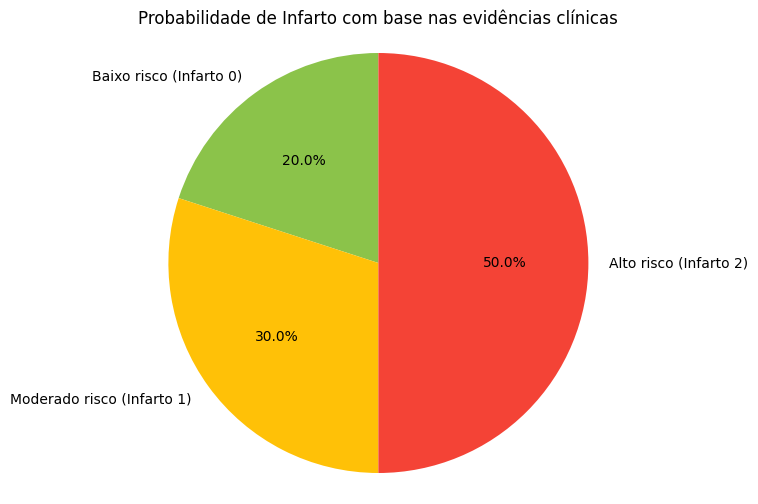

In [32]:
# Probabilidades obtidas da inferência
labels = ['Baixo risco (Infarto 0)', 'Moderado risco (Infarto 1)', 'Alto risco (Infarto 2)']
probabilidades = [0.2, 0.3, 0.5]
cores = ['#8bc34a', '#ffc107', '#f44336']  # Verde, Amarelo, Vermelho

# Criar o gráfico de pizza
plt.figure(figsize=(8, 6))
plt.pie(probabilidades, labels=labels, colors=cores, autopct='%1.1f%%', startangle=90)
plt.title('Probabilidade de Infarto com base nas evidências clínicas')
plt.axis('equal')  # Deixar o gráfico em formato de círculo
plt.show()